# Double Pendulum


Let's setup some parameters

In [120]:
import numpy as np

g        = 9.8             # m/s
l1       = 1.2             # m
l2       = .7              # m
theta1_0 = np.pi/5         # other initial angle
theta2_0 = np.pi           # initial angle
m1       = .10             # kg
m2       = .05             # kg
dt       = 1.e-3           # time steps
max_t    = 5.0             # max time 
nsteps   = long(max_t/dt)  # number of steps

How many steps are there?

In [74]:
print "nsteps:", nsteps

nsteps: 5000


In [75]:
# Import numpy for numerical calculations, vectors, etc.
from numpy import array, zeros, cos, sin, pi
from numpy.linalg import norm as norm
from scipy.integrate import ode

## Helper functions for various calculations

### Calculate various derivatives

The time derivative of $\theta_1$

In [29]:
def dtheta1(theta1, theta2, p1, p2):
    num = l2*p1 - l1*p2*cos(theta1 - theta2)
    den = l1*l1*l2*(m1 + m2*sin(theta1 - theta2)**2)
    return num/den

The time derivative of $\theta_2$

In [20]:
def dtheta2(theta1, theta2, p1, p2):
    num = l1*(m1+m2)*p2 - l2*m2*p1*cos(theta1-theta2)
    den = l1*l2*l2*m2*(m1+ m2*sin(theta1-theta2)**2)
    return num/den

The time derivative of $p_1$

In [21]:
def dp1(theta1, theta2, p1, p2, c1, c2):
    return -(m1+m2)*g*l1*sin(theta1) - c1 + c2

The time derivative of $p_2$

In [22]:
def dp2(theta1, theta2, p1, p2, c1, c2):
    return -m2*g*l2*sin(theta2) + c1 - c2

Helper function to calculate a constant $C_1$

In [23]:
def C1(theta1, theta2, p1, p2):
    num = p1*p2*sin(theta1 - theta2)
    den = l1*l2*(m1 + m2*sin(theta1 - theta2)**2)
    return num/den

Helper function to calculate constant $C_2$

In [24]:
def C2(theta1, theta2, p1, p2):
    num = l2*l2*m2*p1*p2 + l1*(m1 + m2)*p2**2 - l1*l2*m2*p1*p2*cos(theta1-theta2)
    den = 2*l1*l1*l2*l2*(m1 + m2*sin(theta1-theta2)**2)**2*sin(2*(theta1-theta2))
    return num/den

Calculate the derivatives for each $\theta_1,\theta_2,p_1,p_2$

In [31]:
def deriv(t, y):
    theta1, theta2, p1, p2 = y[0], y[1], y[2], y[3]

    _c1 = C1(theta1, theta2, p1, p2)
    _c2 = C2(theta1, theta2, p1, p2)

    _dtheta1 = dtheta1(theta1, theta2, p1, p2)
    _dtheta2 = dtheta2(theta1, theta2, p1, p2)
    
    _dp1 = dp1(theta1, theta2, p1, p2, _c1, _c2)
    _dp2 = dp2(theta1, theta2, p1, p2, _c1, _c2)

    return array([_dtheta1, _dtheta2, _dp1, _dp2])

Use a naive euler integration schemed to make a single step in the pendulum's motion

In [32]:
def euler(theta1, theta2, p1, p2):
    _y = deriv(0, [theta1, theta2, p1, p2])
    _dtheta1, _dtheta2, _dp1, _dp2 = _y[0], _y[1], _y[2], _y[3]

    theta1 += _dtheta1*dt
    theta2 += _dtheta2*dt

    p1 += _dp1*dt
    p2 += _dp2*dt
    
    return theta1, theta2, p1, p2

### Now we need to do the actual calculations

Use a default or specified method of integration to solve the pendulum's motion

In [96]:
def calculate_paths(method = "euler"):

    theta1 = theta1_0
    theta2 = theta2_0
    p1, p2 = 0.0, 0

    paths = []
    
    if method == "euler":
        print "Running EULER method"
        for i in range(nsteps):
            if (i % 500==0): print "Step = %d" % i
            theta1, theta2, p1, p2 = euler(theta1, theta2, p1, p2)
            r1 = array([l1*sin(theta1), -l1*cos(theta1)])
            r2 = r1 + array([l2*sin(theta2), -l2*cos(theta2)])
            paths.append([r1, r2])


    elif method == "scipy":
        print "Running SCIPY method"
        yint = [theta1, theta2, p1, p2]
        # r = ode(deriv).set_integrator('zvode', method='bdf')
        r = ode(deriv).set_integrator('vode', method='bdf')
        r.set_initial_value(yint, 0)
        
        paths = []
        while r.successful() and r.t < max_t:
            r.integrate(r.t+dt)
            theta1, theta2 = r.y[0], r.y[1]
            r1 = array([l1*sin(theta1), -l1*cos(theta1)])
            r2 = r1 + array([l2*sin(theta2), -l2*cos(theta2)])
            paths.append([r1, r2])

    return array(paths)

In [121]:
paths = calculate_paths()

Running EULER method
Step = 0
Step = 500
Step = 1000
Step = 1500
Step = 2000
Step = 2500
Step = 3000
Step = 3500
Step = 4000
Step = 4500


## Plotting the pendulum

Now we want to plot everything!

Import all the good stuff

In [78]:
%pylab inline --no-import-all

import matplotlib
import matplotlib.pyplot as pyplot
from matplotlib import animation
import numpy as np

Populating the interactive namespace from numpy and matplotlib


Plot the paths to a png image pendulum.png

The function a three dimensional numpy array: The first index is over time, the second specifies which mass, the third specifies the cartesian displacement

In [118]:
def plot_paths(paths, IMAGE_PATH = "pendulum.png", TITLE = "Double Pendulum Evolution"):

    # settings for plotting
    YAXIS = "Y"
    XAXIS = "X"

    # Plot the trajectories
    print "Plotting."

    # create a plot
    plt = pyplot.figure(figsize=(15, 10), dpi=80, facecolor='w')
    ax = pyplot.axes()

    # set the title and axis labels
    ax.set_xlabel(XAXIS) 
    ax.set_ylabel(YAXIS)
    ax.set_title(TITLE)

    ax.plot(paths[:, 0, 0], paths[:, 0, 1], "b-", alpha=.7, linewidth=3, label="$m_1$")
    ax.plot(paths[:, 1, 0], paths[:, 1, 1], "g-", alpha=.7, linewidth=3, label="$m_2$")

    # # Objects: draw a dot on the last trajectory point
    ax.plot(paths[-1, 0, 0], paths[-1, 0, 1], "b-")
    ax.plot(paths[-1, 1, 0], paths[-1, 1, 1], "g-")

    # pyplot.axis('equal')
    plt.gca().set_aspect('equal', adjustable='box')

    ax.legend(bbox_to_anchor=(1., 1.), loc="best", 
              ncol=1, fancybox=True, shadow=True)

    # Save our plot
    print "Saving plot to %s." % IMAGE_PATH
    plt.savefig(IMAGE_PATH, bbox_inches='tight')


### Now we can plot!

Plotting.
Saving plot to pendulum.png.


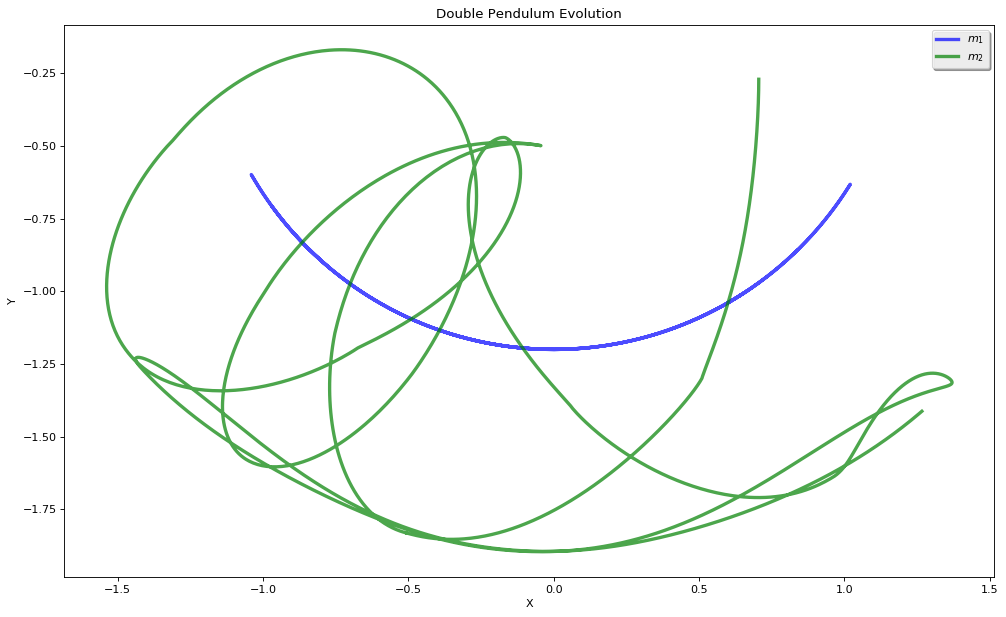

In [122]:
plot_paths(paths)